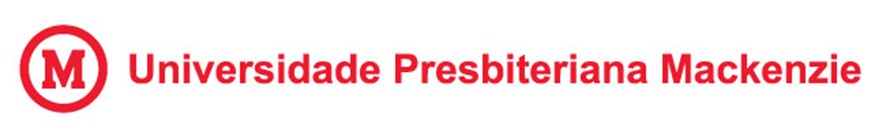

## <font color=red>Projeto Aplicado IV - Sistema de Recomendação

CURSO: Tecnologia em Ciências de Dados

SEMESTRE: 4º

COMPONENTE CURRICULAR / TEMA: PROJETO APLICADO III

NOME DO PROFESSOR: MURILO GLEYSON GAZZOLA

INTEGRANTES E TIA:

1. João Vitor da Silva Pereira
2. NIL NIX MARTOS MIRANDA


### Importando bibliotecas que vamos usar

In [75]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import tensorflow as tf
from IPython.display import Image, display

import requests


# Ignore all warnings
warnings.simplefilter("ignore")

# Ignore specific warnings
warnings.filterwarnings(action="ignore", category=UserWarning)


### A fim de aprimorar a experiência visual, incorporamos uma API que exibe as capas dos filmes.

In [76]:
def obter_capa_do_filme(nome_do_filme):
    api_key = "51502d14"  # Substitua pela sua chave do OMDb API

    # URL da API do OMDb para obter informações sobre o filme
    url = f"http://www.omdbapi.com/?apikey={api_key}&t={nome_do_filme}"

    # Fazendo a solicitação à API
    response = requests.get(url)
    data = response.json()

    # Verifica se a solicitação foi bem-sucedida
    if response.status_code == 200 and data.get("Response") == "True":
        # Obtém a URL da capa do filme
        poster_url = data.get("Poster")
        return poster_url
    else:
        print(f"Erro ao obter informações do filme: {data.get('Error')}")
        return None


In [3]:
# Váriavel com os parametros de conexão com a base de dados 
conn = mysql.connector.connect(user='remoto', password='', host='localhost', database='mackenzie_recomendacao_filmes')

# Criar um objeto cursor para executar consultas SQL
cursor = conn.cursor()

In [4]:
# Consulta SQL
sql_query = "describe mackenzie_recomendacao_filmes.movies"

# Executar a consulta
cursor.execute(sql_query)

# Recuperar os resultados da consulta
results = cursor.fetchall()

print('Describe da base de dados: movies')
# Exibir os resultados
for row in results:
    print(row)

Describe da base de dados: movies
('movieId', 'int', 'YES', '', None, '')
('title', 'varchar(255)', 'YES', '', None, '')
('genresmovies', 'varchar(255)', 'YES', '', None, '')


In [5]:
# Consulta SQL
sql_query = "describe mackenzie_recomendacao_filmes.rating"

# Executar a consulta
cursor.execute(sql_query)

# Recuperar os resultados da consulta
results = cursor.fetchall()

print('Describe da base de dados: rating')
# Exibir os resultados
for row in results:
    print(row)

Describe da base de dados: rating
('userId', 'int', 'YES', '', None, '')
('movieId', 'int', 'YES', '', None, '')
('rating', 'float', 'YES', '', None, '')
('timestamp', 'int', 'YES', '', None, '')


#### Visualizando 10 linhas da tabela de filmes: 

In [6]:
df_movies = pd.read_sql('select * from movies', con=conn)
df_movies.head(10)

,movieId,title,genresmovies
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;
1,2,Jumanji (1995),Adventure|Children|Fantasy;;
2,3,Grumpier Old Men (1995),Comedy|Romance;;
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance;;
4,5,Father of the Bride Part II (1995),Comedy;;
5,6,Heat (1995),Action|Crime|Thriller;;
6,7,Sabrina (1995),Comedy|Romance;;
7,8,Tom and Huck (1995),Adventure|Children;;
8,9,Sudden Death (1995),Action;;
9,10,GoldenEye (1995),Action|Adventure|Thriller;;


#### Visualizando 10 linhas da tabela de avaliações: 

In [7]:
df_rating = pd.read_sql('select * from rating', conn)
df_rating.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119
5,1,381,3.5,1225734105
6,1,596,4.0,1225733524
7,1,1036,5.0,1225735626
8,1,1049,3.0,1225734079
9,1,1066,4.0,1225736961


In [8]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048575 non-null  int64  
 1   movieId    1048575 non-null  int64  
 2   rating     1048575 non-null  float64
 3   timestamp  1048575 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 32.0 MB


In [9]:
filmes = df_movies
# Alterando nomes das colunas
filmes.columns = ["filmeId", "titulo", "generos"]

# Definindo FilmeID como Index
filmes = filmes.set_index("filmeId")
filmes.head()

,titulo,generos
filmeId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;
2,Jumanji (1995),Adventure|Children|Fantasy;;
3,Grumpier Old Men (1995),Comedy|Romance;;
4,Waiting to Exhale (1995),Comedy|Drama|Romance;;
5,Father of the Bride Part II (1995),Comedy;;


In [10]:
notas = df_rating
# Alterando Nomes das Colunas
notas.columns = ["usuarioId", "filmeId", "nota", "momento"]
notas.head()

,usuarioId,filmeId,nota,momento
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [11]:
print('Verificando informações da base de filmes ')
filmes.describe()

Verificando informações da base de filmes 


,titulo,generos
count,85820,85820
unique,78816,1711
top,Toy Story (1995),Drama;;
freq,5,11982


In [12]:
print('Verificando informações da base de Avaliações: ')
notas.describe()

Verificando informações da base de Avaliações: 


,usuarioId,filmeId,nota,momento
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.074567e+03,2.784735e+04,3.525809e+00,1.267337e+09
std,2.868723e+03,4.967106e+04,1.060796e+00,2.505764e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,8.254319e+08
25%,2.633000e+03,1.220000e+03,3.000000e+00,1.057267e+09
50%,4.976000e+03,3.273000e+03,3.500000e+00,1.254270e+09
75%,7.570000e+03,3.639700e+04,4.000000e+00,1.489898e+09
max,1.008200e+04,2.889410e+05,5.000000e+00,1.689838e+09


### Contagem de filmes por gênero

In [13]:
contagem_por_genero = filmes['generos'].str.split('|', expand=True).stack().value_counts()
print("\nNúmero de Filmes por Gênero:")
contagem_por_genero


Número de Filmes por Gênero:


Drama;;                  19338
Drama                    13964
Comedy                   13166
Thriller;;               11539
Comedy;;                  9929
Action                    9064
Romance;;                 9023
Documentary;;             8133
(no genres listed);;      6839
Crime                     5769
Adventure                 4851
Horror                    4323
Horror;;                  4156
Sci-Fi;;                  3687
Children                  3362
Animation                 3210
Mystery                   2290
War;;                     2203
Fantasy;;                 2010
Fantasy                   1755
Western;;                 1615
Mystery;;                 1561
Sci-Fi                    1313
Romance                   1274
Animation;;               1225
Crime;;                   1195
Children;;                 998
Action;;                   799
Documentary                745
Musical;;                  672
Adventure;;                527
Musical                    426
Thriller

### Média de avaliações por filme

In [14]:
# Média de avaliações por filme
media_avaliacao = notas.groupby('filmeId')['nota'].mean()
print("\nMédia de Avaliações por Filme:")
media_avaliacao


Média de Avaliações por Filme:


filmeId
1         3.887833
2         3.291848
3         3.141053
4         3.215278
5         3.144764
            ...   
288753    1.000000
288755    1.000000
288757    0.500000
288939    5.000000
288941    5.000000
Name: nota, Length: 26285, dtype: float64

### Histograma de avaliações

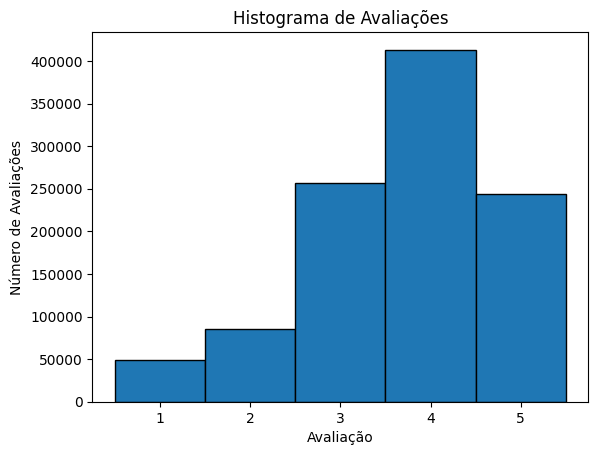

In [15]:
plt.hist(notas['nota'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
plt.title('Histograma de Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Número de Avaliações')
plt.show()

### Gráfico de barras para número de filmes por gênero

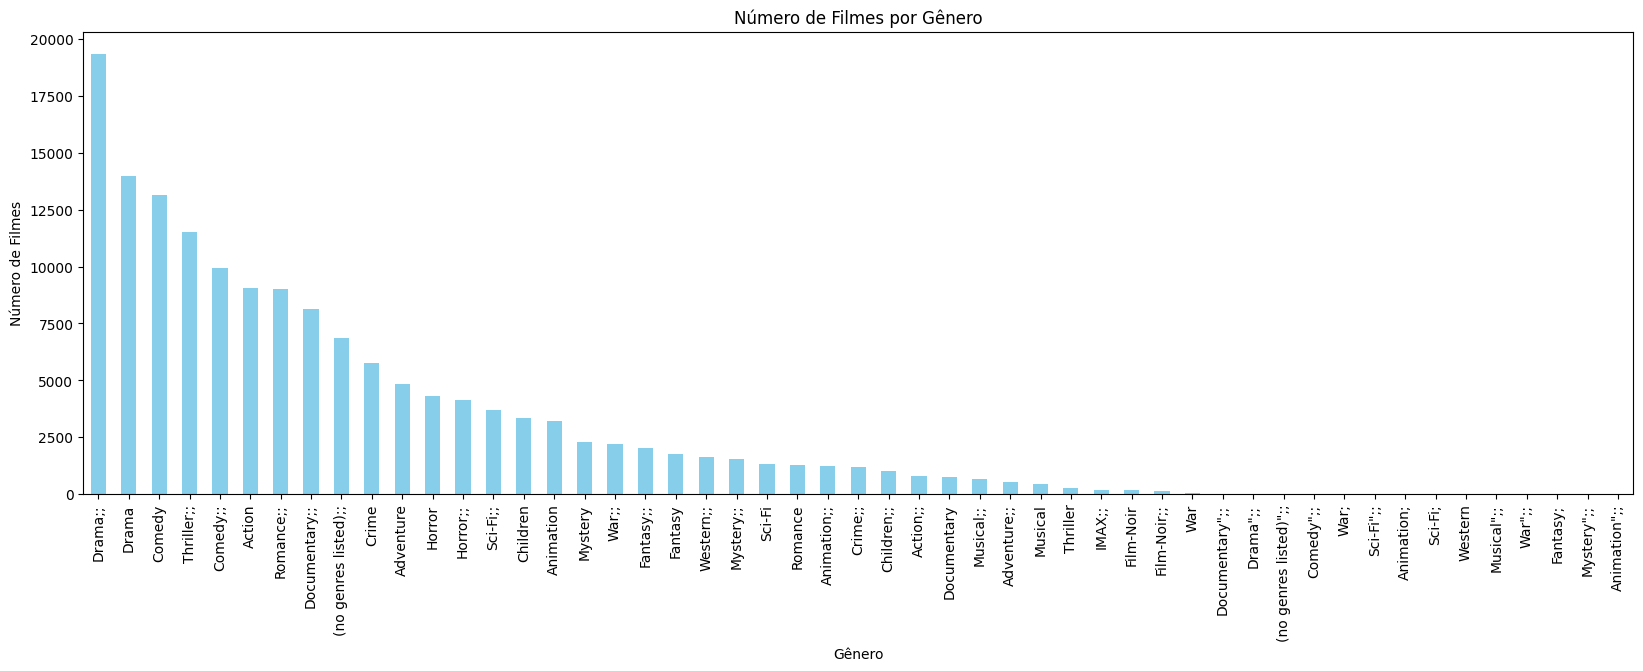

In [16]:
plt.figure(figsize=(20, 6))
contagem_por_genero.plot(kind='bar', color='skyblue')
plt.title('Número de Filmes por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de Filmes')
plt.show()


### Gráfico de dispersão para média de avaliações por filme com aumento lateral

<Figure size 2000x600 with 0 Axes>

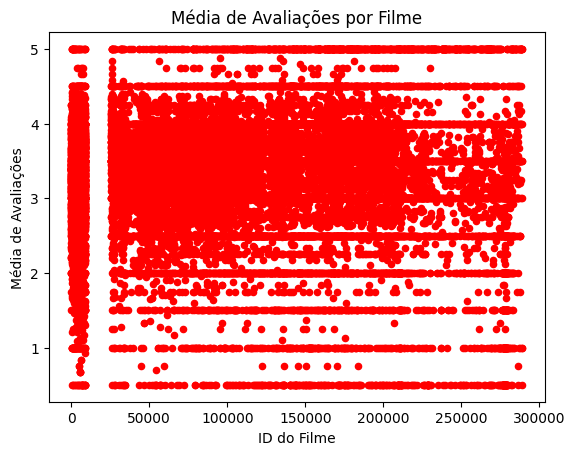

In [17]:

# Média de avaliações por filme
media_avaliacao_1 = notas.groupby('filmeId')['nota'].mean()

# Converter a Série para DataFrame
media_avaliacao_1 = media_avaliacao_1.reset_index()

# Plotando gráfico
plt.figure(figsize=(20, 6))
media_avaliacao_1.plot(kind='scatter', x='filmeId', y='nota', color='red')
plt.title('Média de Avaliações por Filme')
plt.xlabel('ID do Filme')
plt.ylabel('Média de Avaliações')
plt.show()

### Primeira tentativa de recomendação: heurística de total de votos

A seguir, apresentamos nossa primeira incursão na geração de recomendações, baseado no filmes com maior número de votos e médias mais altas. Este processo visa identificar e oferecer aos usuários filmes que não apenas foram amplamente avaliados, indicando uma popularidade consolidada, mas também mantêm uma classificação média notavelmente superior. 

In [18]:
print('Contagem por FilmesID de cada filme')
total_de_votos = notas["filmeId"].value_counts()
total_de_votos.head(10)

Contagem por FilmesID de cada filme


filmeId
318     3735
356     3505
296     3325
2571    3320
593     3172
260     3009
2959    2638
527     2627
480     2547
4993    2500
Name: count, dtype: int64

In [19]:
# adicionando Contagem de Votos em cada Filme
filmes['total_de_votos'] = total_de_votos
filmes.head(10)

,titulo,generos,total_de_votos
filmeId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0
2,Jumanji (1995),Adventure|Children|Fantasy;;,920.0
3,Grumpier Old Men (1995),Comedy|Romance;;,475.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance;;,72.0
5,Father of the Bride Part II (1995),Comedy;;,487.0
6,Heat (1995),Action|Crime|Thriller;;,949.0
7,Sabrina (1995),Comedy|Romance;;,483.0
8,Tom and Huck (1995),Adventure|Children;;,45.0
9,Sudden Death (1995),Action;;,150.0


In [20]:
filmes.sort_values("total_de_votos", ascending = False).head(10)

,titulo,generos,total_de_votos
filmeId,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0


In [21]:
# Adicionando média de notas na base de filmes
notas_medias = notas.groupby("filmeId").mean()["nota"]
filmes["nota_media"] = notas_medias
filmes.sort_values("total_de_votos", ascending = False).head(10)

,titulo,generos,total_de_votos,nota_media
filmeId,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737


In [22]:
# Agrupa por filmeId e calcula os valores máximos e únicos
result1 = filmes.groupby('filmeId').agg({'titulo': 'first', 'generos': 'first', 'total_de_votos': 'max', 'nota_media': 'max'}).reset_index()

# Ordena pelos valores desejados em ordem decrescente
result1 = result1.sort_values(by=['total_de_votos', 'nota_media'], ascending=False)

# Obtém os top 5 filmes
primeiro_top_5 = result1.head(5)


### Resultados: heurística de total de votos


In [23]:
primeiro_top_5['titulo']

285                           Forrest Gump (1994)
243                           Pulp Fiction (1994)
213     Star Wars: Episode IV - A New Hope (1977)
2146                            Fight Club (1999)
417                       Schindler's List (1993)
Name: titulo, dtype: object

In [24]:
def vendo_resultados(lista_filmes):

    # Printando Recomendações
    i = 1
    for nome_do_filme in lista_filmes:
        print(i, end='')
        print('º Lugar: ', end='')
        print(nome_do_filme)
        url_da_capa = obter_capa_do_filme(nome_do_filme)
        display(Image(url=url_da_capa))
        i += 1



In [25]:
# Remover a data de criação dos filmes na coluna 'titulo'
primeiro_top_5['titulo'] = primeiro_top_5['titulo'].str.replace(r'\(\d+\)', '', regex=True)
vendo_resultados(primeiro_top_5['titulo'])

1º Lugar: Forrest Gump 


2º Lugar: Pulp Fiction 


3º Lugar: Star Wars: Episode IV - A New Hope 


4º Lugar: Fight Club 


5º Lugar: Schindler's List 


In [26]:
# Verificando destalhes
primeiro_top_5

,filmeId,titulo,generos,total_de_votos,nota_media
285,356,Forrest Gump,Comedy|Drama|Romance|War;;,3505.0,4.048787
243,296,Pulp Fiction,Comedy|Crime|Drama|Thriller;;,3325.0,4.194737
213,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi;;,3009.0,4.063476
2146,2959,Fight Club,Action|Crime|Drama|Thriller;;,2638.0,4.223654
417,527,Schindler's List,Drama|War;;,2627.0,4.199467



#### vantagens desse modelo:
Aprovação da Maioria:
    ºFilmes populares geralmente agradam à maioria dos usuários.

Confiança do Usuário:
    ºRecomendações baseadas em popularidade ganham a confiança dos usuários.

Simplicidade:
    ºFácil de entender e implementar.

#### Desvantagens desse modelo:

Falta de Personalização:
    ºNão considera preferências individuais.

Estagnação de Conteúdo:
    ºPode limitar a descoberta de novos filmes.

Ignora Preferências Niche:
    ºFilmes menos populares podem ser ignorados.

Não Leva em Conta Mudanças de Gosto:
    ºNão reflete mudanças nas preferências dos usuários.

Possíveis Viéses:
    ºPode ser influenciado por marketing e modismos, não refletindo necessariamente qualidade intrínseca.


### Segunda tentativa de recomendação: Baseada em Memória

Este método tenta encontrar usuários semelhantes ao usuário alvo e usa suas
preferências para prever classificações para este usuário. As classificações ou interações são
usadas para calcular a semelhança e o peso entre usuários ou itens. 

In [27]:
def distancia_de_vetores(a,b):
  return np.linalg.norm(a - b)

In [28]:
def notas_do_usuario(usuario):
  notas_do_usuario = notas.query("usuarioId==%d" % usuario)
  notas_do_usuario = notas_do_usuario[["filmeId", "nota"]].set_index("filmeId")
  return notas_do_usuario

usuario1 = notas_do_usuario(1)
usuario4 = notas_do_usuario(4)


In [29]:
usuario1.head()

,nota
filmeId,
1,4.0
110,4.0
158,4.0
260,4.5
356,5.0


In [30]:
usuario4.head()

,nota
filmeId,
260,5.0
318,5.0
356,5.0
595,4.5
858,3.0


In [31]:
diferencas = usuario1.join(usuario4, lsuffix="_esquerda", rsuffix="_direita").dropna()
distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])

1.3228756555322954

In [32]:
def distancia_de_usuarios(usuario_id1, usuario_id2):
  notas1 = notas_do_usuario(usuario_id1)
  notas2 = notas_do_usuario(usuario_id2)
  diferencas = notas1.join(notas2, lsuffix="_esquerda", rsuffix="_direita").dropna()
  distancia =  distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])
  return [usuario_id1, usuario_id2, distancia]

In [33]:
distancia_de_usuarios(1,4)

[1, 4, 1.3228756555322954]

In [34]:
quantidade_de_usuarios = len(notas['usuarioId'].unique())
print("Temos %d usuarios" % quantidade_de_usuarios)

Temos 10082 usuarios


Função distancia_de_usuarios realiza o cálculo da distância euclidiana entre dois usuários com base em suas notas, com a condição de ter um número mínimo de notas em comum. Se o número mínimo de notas não for atendido, a função retorna um valor alto indicando uma grande distância.

In [35]:
def distancia_de_todos(voce_id):
  todos_os_usuarios = notas['usuarioId'].unique()
  distancias = [distancia_de_usuarios(voce_id, usuario_id) for usuario_id in todos_os_usuarios]
  distancias = pd.DataFrame(distancias, columns = ["voce", "outra_pessoa", "distancia"])
  return distancias

distancia_de_todos(1).head()

,voce,outra_pessoa,distancia
0,1,1,0.000000
1,1,2,1.732051
2,1,3,0.500000
3,1,4,1.322876
4,1,5,3.500000


In [36]:
notas_do_usuario(1).join(notas_do_usuario(5), lsuffix="_1", rsuffix="5").dropna()

,nota_1,nota5
filmeId,,
356,5.0,3.0
2028,5.0,4.0
2571,2.5,5.0
2762,5.0,4.0


In [37]:
notas_do_usuario(1).join(notas_do_usuario(2), lsuffix="_1", rsuffix="2").dropna()

,nota_1,nota2
filmeId,,
1,4.0,5.0
110,4.0,5.0
158,4.0,3.0
356,5.0,5.0


In [38]:
notas_do_usuario(1).join(notas_do_usuario(3), lsuffix="_1", rsuffix="3").dropna()

,nota_1,nota3
filmeId,,
4886,5.0,5.0
8961,4.5,5.0


Usuários que não compartilham nenhum filme em comum são posicionados significativamente distantes entre si:

In [39]:
def distancia_de_usuarios(usuario_id1, usuario_id2, minimo = 5):
  notas1 = notas_do_usuario(usuario_id1)
  notas2 = notas_do_usuario(usuario_id2)
  diferencas = notas1.join(notas2, lsuffix="_esquerda", rsuffix="_direita").dropna()
  
  if(len(diferencas) < minimo):
    return [usuario_id1, usuario_id2, 100000]
  
  distancia =  distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])
  return [usuario_id1, usuario_id2, distancia]

In [40]:
distancia_de_todos(1).head()

,voce,outra_pessoa,distancia
0,1,1,0.000000
1,1,2,100000.000000
2,1,3,100000.000000
3,1,4,1.322876
4,1,5,100000.000000


In [41]:
def mais_proximos_de(voce_id):
  distancias = distancia_de_todos(voce_id)
  distancias = distancias.sort_values("distancia")
  distancias = distancias.set_index("outra_pessoa").drop(voce_id)
  return distancias

In [42]:
mais_proximos_de(1).head()

,voce,distancia
outra_pessoa,,
3388,1,0.000000
8500,1,0.500000
5755,1,0.500000
3922,1,0.707107
3383,1,0.707107


### Parâmetros para testarmos o modelo:

In [43]:
def mais_proximos_de(voce_id, n=None):
    # Calcula as distâncias entre a pessoa 'voce_id' e todas as outras pessoas
    distancias = distancia_de_todos(voce_id, n=n)

    # Ordena as distâncias em ordem crescente
    distancias = distancias.sort_values("distancia")

    # Define a outra pessoa como índice e remove a entrada correspondente à pessoa 'voce_id'
    distancias = distancias.set_index("outra_pessoa").drop(voce_id)

    # Retorna o DataFrame contendo as distâncias ordenadas
    return distancias


In [44]:
def distancia_de_todos(voce_id, n=None):
    # Obtém todos os IDs de usuário únicos no conjunto de dados de notas
    todos_os_usuarios = notas['usuarioId'].unique()

    # Se n for especificado, limita a análise aos primeiros n usuários
    if n:
        todos_os_usuarios = todos_os_usuarios[:n]

    # Calcula a distância entre 'voce_id' e todos os outros usuários
    distancias = [distancia_de_usuarios(voce_id, usuario_id) for usuario_id in todos_os_usuarios]

    # Cria um DataFrame com as distâncias calculadas
    distancias = pd.DataFrame(distancias, columns=["voce", "outra_pessoa", "distancia"])

    # Retorna o DataFrame contendo as distâncias
    return distancias


In [45]:
# Obtém os 50 usuários mais próximos ao usuário com o ID 1 com base na distância euclidiana
mais_proximos_de(1, n = 50)

,voce,distancia
outra_pessoa,,
4,1,1.322876
42,1,1.936492
17,1,2.500000
29,1,3.354102
11,1,3.464102
37,1,3.535534
7,1,3.674235
30,1,3.840573
31,1,4.000000


In [46]:
def distancia_de_usuarios(usuario_id1, usuario_id2, minimo=5):
    # Obtém as notas atribuídas pelo usuario_id1 e usuario_id2
    notas1 = notas_do_usuario(usuario_id1)
    notas2 = notas_do_usuario(usuario_id2)
    
    # Combina as notas dos dois usuários, deixando apenas aquelas que têm correspondência
    diferencas = notas1.join(notas2, lsuffix="_esquerda", rsuffix="_direita").dropna()

    # Verifica se há um número mínimo de notas compartilhadas para calcular a distância
    if len(diferencas) < minimo:
        return None  # Retorna None se não houver notas suficientes para calcular uma distância significativa

    # Calcula a distância entre os vetores de notas dos dois usuários
    distancia = distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])
    
    # Retorna uma lista contendo os IDs dos usuários e a distância calculada
    return [usuario_id1, usuario_id2, distancia]


In [47]:
def distancia_de_todos(voce_id, numero_de_usuarios_a_analisar=None):
    # Obtém todos os IDs de usuário únicos no conjunto de dados de notas
    todos_os_usuarios = notas['usuarioId'].unique()

    # Se numero_de_usuarios_a_analisar for especificado, limita a análise aos primeiros n usuários
    if numero_de_usuarios_a_analisar:
        todos_os_usuarios = todos_os_usuarios[:numero_de_usuarios_a_analisar]

    # Calcula a distância entre 'voce_id' e todos os outros usuários
    distancias = [distancia_de_usuarios(voce_id, usuario_id) for usuario_id in todos_os_usuarios]

    # Remove as entradas None (quando o número mínimo de notas compartilhadas não é atendido)
    distancias = list(filter(None, distancias))

    # Cria um DataFrame com as distâncias calculadas
    distancias = pd.DataFrame(distancias, columns=["voce", "outra_pessoa", "distancia"])

    # Retorna o DataFrame contendo as distâncias
    return distancias


In [48]:
def mais_proximos_de(voce_id, numero_de_usuarios_a_analisar=None):
    # Calcula as distâncias entre a pessoa 'voce_id' e todos os outros usuários
    distancias = distancia_de_todos(voce_id, numero_de_usuarios_a_analisar=numero_de_usuarios_a_analisar)

    # Ordena as distâncias em ordem crescente
    distancias = distancias.sort_values("distancia")

    # Define a outra pessoa como índice e remove a entrada correspondente à pessoa 'voce_id'
    distancias = distancias.set_index("outra_pessoa").drop(voce_id)

    # Retorna o DataFrame contendo as distâncias ordenadas
    return distancias


In [49]:
# Obtém os 50 usuários mais próximos ao usuário com o ID 1 com base na distância euclidiana
resultado = mais_proximos_de(1, numero_de_usuarios_a_analisar=50)

In [50]:
resultado.head(5)

,voce,distancia
outra_pessoa,,
4,1,1.322876
42,1,1.936492
17,1,2.500000
29,1,3.354102
11,1,3.464102


In [51]:
def sugere_para(voce, numero_de_usuarios_a_analisar=None):
    # Obtém as notas atribuídas pelo usuário 'voce'
    notas_de_voce = notas_do_usuario(voce)
    
    # Obtém os IDs dos filmes que 'voce' já assistiu
    filmes_que_voce_ja_viu = notas_de_voce.index

    # Obtém os usuários mais próximos a 'voce' com base na distância euclidiana
    similares = mais_proximos_de(voce, numero_de_usuarios_a_analisar=numero_de_usuarios_a_analisar)
    
    # Pega o ID do usuário mais similar
    similar = similares.iloc[0].name
    
    # Obtém as notas atribuídas pelo usuário mais similar
    notas_do_similar = notas_do_usuario(similar)
    
    # Remove os filmes que 'voce' já assistiu das notas do usuário similar
    notas_do_similar = notas_do_similar.drop(filmes_que_voce_ja_viu, errors='ignore')
    
    # Ordena as recomendações com base nas notas, em ordem decrescente
    recomendacoes = notas_do_similar.sort_values("nota", ascending=False)
    
    # Junta as recomendações com informações sobre os filmes
    return recomendacoes.join(filmes)


In [52]:
# Obtém as recomendações para o usuário com ID 1, baseado nos 50 usuários mais próximos
recomendacoes = sugere_para(1, numero_de_usuarios_a_analisar=50)

# Exibe as primeiras linhas das recomendações
recomendacoes.head()


,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
318,5.0,NaN,NaN,NaN,NaN
595,4.5,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX;;,1408.0,3.635298
595,4.5,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX;;,1408.0,3.635298
858,3.0,NaN,NaN,NaN,NaN
915,4.0,Sabrina (1954),Comedy|Romance;;,200.0,3.850000


In [53]:
# Obtém recomendações para o usuário com ID 1, sem limitação no número de usuários para análise
recomendacoes = sugere_para(1)

# Exibe as primeiras linhas das recomendações
recomendacoes.head()


,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678


### Sugerindo baseado em vários usuários

In [54]:
def mais_proximos_de(voce_id, n_mais_proximos=10, numero_de_usuarios_a_analisar=None):
    # Calcula as distâncias entre a pessoa 'voce_id' e todos os outros usuários
    distancias = distancia_de_todos(voce_id, numero_de_usuarios_a_analisar=numero_de_usuarios_a_analisar)
    
    # Ordena as distâncias em ordem crescente
    distancias = distancias.sort_values("distancia")
    
    # Define a outra pessoa como índice e remove a entrada correspondente à pessoa 'voce_id'
    distancias = distancias.set_index("outra_pessoa").drop(voce_id)
    
    # Retorna os 'n_mais_proximos' usuários mais próximos
    return distancias.head(n_mais_proximos)


In [55]:
# Obtém os 2 usuários mais próximos ao usuário com ID 1, considerando os primeiros 300 usuários
proximos_usuarios = mais_proximos_de(1, n_mais_proximos=2, numero_de_usuarios_a_analisar=300)

# Exibe os usuários mais próximos
proximos_usuarios


,voce,distancia
outra_pessoa,,
99,1,1.224745
4,1,1.322876


In [56]:
def sugere_para(voce, n_mais_proximos=10, numero_de_usuarios_a_analisar=None):
    # Obtém as notas atribuídas pelo usuário 'voce'
    notas_de_voce = notas_do_usuario(voce)
    
    # Obtém os IDs dos filmes que 'voce' já assistiu
    filmes_que_voce_ja_viu = notas_de_voce.index

    # Obtém os 'n_mais_proximos' usuários mais próximos a 'voce'
    similares = mais_proximos_de(voce, n_mais_proximos=n_mais_proximos, numero_de_usuarios_a_analisar=numero_de_usuarios_a_analisar)
    
    # Obtém os IDs dos usuários similares
    usuarios_similares = similares.index
    
    # Obtém as notas dos usuários similares para todos os filmes
    notas_dos_similares = notas.set_index("usuarioId").loc[usuarios_similares]
    
    # Calcula a média das notas por filme atribuídas pelos usuários similares
    recomendacoes = notas_dos_similares.groupby("filmeId").mean()[["nota"]]
    
    # Ordena as recomendações com base nas médias das notas, em ordem decrescente
    recomendacoes = recomendacoes.sort_values("nota", ascending=False)
    
    # Junta as recomendações com informações sobre os filmes
    return recomendacoes.join(filmes)


### Resultados: recomendação baseado em distância euclidiana


Essa linha de código irá calcular as recomendações para o usuário com ID 50, exibindo as primeiras linhas do DataFrame resultante. As recomendações serão ordenadas com base na média das notas, do mais alto para o mais baixo.

In [57]:
resultados3 = sugere_para(50)
resultados4 = resultados3.drop_duplicates(subset='titulo')
# Obtém os top 5 filmes
segundo_top_5 = resultados4.head(5)

In [58]:
# Remover a data de criação dos filmes na coluna 'titulo'
segundo_top_5['titulo'] = segundo_top_5['titulo'].str.replace(r'\(\d+\)', '', regex=True)
vendo_resultados(segundo_top_5['titulo'])

1º Lugar: Toy Story 


2º Lugar: Jumanji 


3º Lugar: Grumpier Old Men 


4º Lugar: Waiting to Exhale 


5º Lugar: Heat 


In [59]:
# Mostrando mais informações dos filmes acimas:
resultados4.head(5)

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
1,5.00,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
2,3.00,Jumanji (1995),Adventure|Children|Fantasy;;,920.0,3.291848
3,2.75,Grumpier Old Men (1995),Comedy|Romance;;,475.0,3.141053
4,3.00,Waiting to Exhale (1995),Comedy|Drama|Romance;;,72.0,3.215278
6,2.50,Heat (1995),Action|Crime|Thriller;;,949.0,3.827187



### Vantagens do Sistema de Recomendação Baseado em Distância Euclidiana:

Simplicidade conceitual.

Facilidade de implementação.

Interpretabilidade.

Robustez em espaços euclidianos.
### Desvantagens

Sensibilidade a outliers.

Problemas com dimensionalidade.

Tratamento inadequado de dados esparsos.

Dependência da escala.

Falta de consideração de relações não-lineares.

Necessidade de pré-processamento adequado.

### Terceira tentativa de recomendação: Baseada em Memória

Este método tenta encontrar usuários semelhantes ao usuário alvo e usa suas
preferências para prever classificações para este usuário. As classificações ou interações são
usadas para calcular a semelhança e o peso entre usuários ou itens. 

In [63]:
# Convertendo o DataFrame pandas Movies para um conjunto de dados do TensorFlow

features = {
    'movie_title': tf.constant(filmes['titulo'])
}
movies = tf.data.Dataset.from_tensor_slices(features)

In [64]:
movies

<TensorSliceDataset element_spec={'movie_title': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [65]:
movies1 = pd.DataFrame(movies)
movies1

,movie_title
0,"tf.Tensor(b'Toy Story (1995)', shape=(), dtype..."
1,"tf.Tensor(b'Jumanji (1995)', shape=(), dtype=s..."
2,"tf.Tensor(b'Grumpier Old Men (1995)', shape=()..."
3,"tf.Tensor(b'Waiting to Exhale (1995)', shape=(..."
4,tf.Tensor(b'Father of the Bride Part II (1995)...
...,...
85815,tf.Tensor(b'State of Siege: Temple Attack (202...
85816,"tf.Tensor(b'Ouija Japan (2021)', shape=(), dty..."
85817,tf.Tensor(b'The Men Who Made the Movies: Howar...
85818,"tf.Tensor(b'Skinford: Death Sentence (2023)', ..."


In [66]:
# Mesclar os DataFrames com base na coluna "filmeId"
merged_df = pd.merge(notas, filmes, on='filmeId')

# Criar um terceiro DataFrame com as colunas desejadas
terceiro_df = merged_df[['titulo', 'usuarioId']]

In [68]:
# Convertendo os campos user_id para o formato de string
terceiro_df['user_id'] = terceiro_df['usuarioId'].astype(str)

# Convertendo o DataFrame pandas Notas para um conjunto de dados do TensorFlow
features = {
    'movie_title': tf.constant(terceiro_df['titulo']),
    'user_id': tf.constant(terceiro_df['user_id'])
}
ratings = tf.data.Dataset.from_tensor_slices(features)

Construindo Volubulários para converter IDs de Usuários e títulos de filmes em Índices inteiros para camadas de incorporação:

In [69]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

In [70]:
movies = movies.map(lambda x: x["movie_title"])
movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

### Definindo Modelo


In [71]:
import tensorflow_recommenders as tfrs
from typing import Dict, Text


class MovieLensModel(tfrs.Model):


  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()


    self.user_model = user_model
    self.movie_model = movie_model


    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)


Definindo os dois modelos e a tarefa de recuperação.

In [72]:
# Definindo modelo de usuários e filmes
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Definindo objetivos
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)


### Ajustando e avaliando modelo

Criando Modelo, treinando e realizando previsões



In [74]:
# Crie um modelo de recuperação.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Treinando 3 Épocas
model.fit(ratings.batch(4096), epochs=3)

# Use uma busca de força bruta para configurar a recuperação usando as representações treinadas.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

# Capturando recomendações
_, titles = index(np.array(["50"]))
print(f"Melhores recomendações para o usuário ID 50: {titles[0, :5]}")

Epoch 1/3
416/416 [==============================] - 10807s 26s/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.0100 - factorized_top_k/top_10_categorical_accuracy: 0.0225 - factorized_top_k/top_50_categorical_accuracy: 0.0646 - factorized_top_k/top_100_categorical_accuracy: 0.0834 - loss: 35285.7838 - regularization_loss: 0.0000e+00 - total_loss: 35285.7838
Epoch 2/3
416/416 [==============================] - 9705s 23s/step - factorized_top_k/top_1_categorical_accuracy: 7.6364e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0022 - factorized_top_k/top_10_categorical_accuracy: 0.0041 - factorized_top_k/top_50_categorical_accuracy: 0.0175 - factorized_top_k/top_100_categorical_accuracy: 0.0319 - loss: 33995.1880 - regularization_loss: 0.0000e+00 - total_loss: 33995.1880
Epoch 3/3
416/416 [==============================] - 9542s 23s/step - factorized_top_k/top_1_categorical_accuracy: 0.0016 - factorized_top_k/top_5_categori

### Resultados: Recomendação usando método de Classificação


In [90]:
# Exibindo resultados
vendo_resultados(titles)

1º Lugar: The Joke Thief


2º Lugar: Batman: Gotham by Gaslight


3º Lugar: First Love


4º Lugar: Guns Akimbo


5º Lugar: Fighting with My Family


factorized_top_k/top_1_categorical_accuracy: 

    factorized_top_k/top_1_categorical_accuracy é a precisão quando o item correto está no top 1 das recomendações.
loss: 32549.6088: 

    Isso representa o valor da função de perda do modelo durante o treinamento. O objetivo é minimizar essa perda.
regularization_loss: 0.0000e+00: Mostra a perda de regularização, que é uma penalidade aplicada ao modelo para evitar overfitting.

total_loss: 32549.6088: 
    A soma da perda e da perda de regularização, representando o custo total do modelo.